In [ ]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Input, SimpleRNN, Dense, Flatten, RepeatVector, Concatenate, TimeDistributed

# 가상의 데이터 생성
# 데이터의 형태는 실제 데이터셋에 따라 조정되어야 합니다.
num_samples = 1000
max_seq_length = 10
theta = np.random.rand(num_samples, 1) * 2 * np.pi
phi = np.random.rand(num_samples, 1) * 2 * np.pi
sequence = np.random.randint(5, size=(num_samples, max_seq_length))

In [ ]:
# 각각을 독립적인 입력으로 처리
theta_input = Input(shape=(1,), name='theta_input')
phi_input = Input(shape=(1,), name='phi_input')
sequence_input = Input(shape=(max_seq_length,), name='sequence_input')

# theta와 phi를 시퀀스의 각 타임스텝에 반복
theta_repeated = RepeatVector(max_seq_length)(theta_input)
phi_repeated = RepeatVector(max_seq_length)(phi_input)

# 시퀀스 임베딩
sequence_embedding = Embedding(5, 32, input_length=max_seq_length)(sequence_input)

# 입력들을 합침
concat_layer = Concatenate()([theta_repeated, phi_repeated, sequence_embedding])

In [ ]:
# RNN 레이어
rnn_layer = SimpleRNN(32, return_sequences=True)(concat_layer)

# 출력 레이어
output = TimeDistributed(Dense(5, activation='softmax'))(rnn_layer)

# 모델 정의
model = Model(inputs=[theta_input, phi_input, sequence_input], outputs=output)

# 모델 학습
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit({'theta_input': theta, 'phi_input': phi, 'sequence_input': sequence}, np.expand_dims(sequence, -1), epochs=10, validation_split=0.2)

# 새로운 theta와 phi 값에 대한 리스트 예측
new_theta = np.array([[0.5]])
new_phi = np.array([[0.5]])
new_sequence = np.zeros((1, max_seq_length))  # 초기 시퀀스는 0으로 설정
predicted_sequence = model.predict({'theta_input': new_theta, 'phi_input': new_phi, 'sequence_input': new_sequence})


In [3]:
print(predicted_sequence)

[[[0.9740461  0.00150249 0.00283895 0.01172099 0.00989156]
  [0.97008383 0.00176454 0.00280468 0.01278157 0.01256536]
  [0.97046465 0.00215553 0.00204273 0.01330278 0.01203432]
  [0.97573686 0.00154915 0.00209132 0.01182453 0.00879812]
  [0.97263134 0.00177073 0.00224956 0.01358771 0.00976066]
  [0.9699743  0.00179466 0.00233559 0.01333149 0.01256401]
  [0.96921283 0.00174713 0.00245519 0.01340958 0.01317524]
  [0.96838456 0.00177329 0.00252713 0.01274544 0.01456957]
  [0.9679192  0.00183257 0.00249692 0.01215918 0.01559203]
  [0.9679409  0.00191405 0.00246025 0.01212933 0.01555538]]]


***

In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Embedding, RepeatVector, Concatenate, TimeDistributed

# CSV 파일에서 데이터 읽기
df = pd.read_csv('ByAstar_20230627_093742.csv')

# theta, phi 값 불러오기
theta = df['Theta'].values.reshape(-1, 1)
phi = df['Phi'].values.reshape(-1, 1)

# sequence를 리스트로 변환
sequence = df['combination'].apply(eval).to_list()

# 시퀀스의 최대 길이 계산
max_seq_length = max(len(seq) for seq in sequence)

# 시퀀스를 동일한 길이로 패딩
sequence_padded = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=max_seq_length)

# 데이터를 훈련 세트와 테스트 세트로 분할
theta_train, theta_test, phi_train, phi_test, sequence_train, sequence_test = train_test_split(theta, phi, sequence_padded, test_size=0.2, random_state=42)

# 입력 레이어 생성
theta_input = Input(shape=(1,), name='theta_input')
phi_input = Input(shape=(1,), name='phi_input')
sequence_input = Input(shape=(max_seq_length,), name='sequence_input')

# theta와 phi를 시퀀스의 각 타임스텝에 반복
theta_repeated = RepeatVector(max_seq_length)(theta_input)
phi_repeated = RepeatVector(max_seq_length)(phi_input)

# 시퀀스 임베딩
sequence_embedding = Embedding(5, 32, input_length=max_seq_length)(sequence_input)

# 입력들을 합침
concat_layer = Concatenate()([theta_repeated, phi_repeated, sequence_embedding])

# RNN 레이어
rnn_layer = SimpleRNN(32, return_sequences=True)(concat_layer)

# 출력 레이어
output = TimeDistributed(Dense(5, activation='softmax'))(rnn_layer)

# 모델 정의
model = Model(inputs=[theta_input, phi_input, sequence_input], outputs=output)

# 모델 컴파일
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 학습
history = model.fit({'theta_input': theta_train, 'phi_input': phi_train, 'sequence_input': sequence_train}, np.expand_dims(sequence_train, -1), epochs=10, validation_data=({'theta_input': theta_test, 'phi_input': phi_test, 'sequence_input': sequence_test}, np.expand_dims(sequence_test, -1)))

# 테스트 세트에 대한 리스트 예측
predicted_sequence = model.predict({'theta_input': theta_test, 'phi_input': phi_test, 'sequence_input': sequence_test})

# 첫 5개의 예측된 시퀀스 출력
for i in range(10):
    print(f"True sequence: {sequence_test[i]}")
    print(f"Predicted sequence: {np.argmax(predicted_sequence[i], axis=1)}\n")


Epoch 1/10
20/20 [==============================] - 1s 16ms/step - loss: 1.7247 - accuracy: 0.2138 - val_loss: 1.4150 - val_accuracy: 0.3699
Epoch 2/10
20/20 [==============================] - 0s 6ms/step - loss: 1.2979 - accuracy: 0.4916 - val_loss: 1.1453 - val_accuracy: 0.5563
Epoch 3/10
20/20 [==============================] - 0s 7ms/step - loss: 1.0139 - accuracy: 0.6434 - val_loss: 0.8280 - val_accuracy: 0.7586
Epoch 4/10
20/20 [==============================] - 0s 7ms/step - loss: 0.6950 - accuracy: 0.8454 - val_loss: 0.5239 - val_accuracy: 0.9176
Epoch 5/10
20/20 [==============================] - 0s 7ms/step - loss: 0.4266 - accuracy: 0.9256 - val_loss: 0.3131 - val_accuracy: 0.9464
Epoch 6/10
20/20 [==============================] - 0s 7ms/step - loss: 0.2694 - accuracy: 0.9510 - val_loss: 0.2104 - val_accuracy: 0.9589
Epoch 7/10
20/20 [==============================] - 0s 6ms/step - loss: 0.1869 - accuracy: 0.9646 - val_loss: 0.1540 - val_accuracy: 0.9721
Epoch 8/10
20/20 [=

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Embedding, RepeatVector, Concatenate, TimeDistributed

# CSV 파일에서 데이터 읽기
df = pd.read_csv('ByAstar_20230627_093742.csv')

# theta, phi 값 불러오기
theta = df['Theta'].values.reshape(-1, 1)
phi = df['Phi'].values.reshape(-1, 1)

# sequence를 리스트로 변환
sequence = df['combination'].apply(eval).to_list()

# 시퀀스의 최대 길이 계산
max_seq_length = max(len(seq) for seq in sequence)

# 시퀀스를 동일한 길이로 패딩
sequence_padded = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=max_seq_length)

# 데이터를 훈련 세트와 테스트 세트로 분할
theta_train, theta_test, phi_train, phi_test, sequence_train, sequence_test = train_test_split(theta, phi, sequence_padded, test_size=0.2, random_state=42)

# 입력 레이어 생성
theta_input = Input(shape=(1,), name='theta_input')
phi_input = Input(shape=(1,), name='phi_input')
sequence_input = Input(shape=(max_seq_length,), name='sequence_input')

# theta와 phi를 시퀀스의 각 타임스텝에 반복
theta_repeated = RepeatVector(max_seq_length)(theta_input)
phi_repeated = RepeatVector(max_seq_length)(phi_input)

# 시퀀스 임베딩
sequence_embedding = Embedding(5, 32, input_length=max_seq_length)(sequence_input)

# 입력들을 합침
concat_layer = Concatenate()([theta_repeated, phi_repeated, sequence_embedding])

# RNN 레이어
rnn_layer = SimpleRNN(32, return_sequences=True)(concat_layer)

# 출력 레이어
output = TimeDistributed(Dense(5, activation='softmax'))(rnn_layer)

# 모델 정의
model = Model(inputs=[theta_input, phi_input, sequence_input], outputs=output)

# 모델 컴파일
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 학습
history = model.fit({'theta_input': theta_train, 'phi_input': phi_train, 'sequence_input': sequence_train}, np.expand_dims(sequence_train, -1), epochs=10, validation_data=({'theta_input': theta_test, 'phi_input': phi_test, 'sequence_input': sequence_test}, np.expand_dims(sequence_test, -1)))

# 테스트 세트에 대한 리스트 예측
predicted_sequence = model.predict({'theta_input': theta_test, 'phi_input': phi_test, 'sequence_input': sequence_test})

# 첫 5개의 예측된 시퀀스 출력
for i in range(5):
    print(f"True sequence: {sequence_test[i]}")
    print(f"Predicted sequence: {np.argmax(predicted_sequence[i], axis=1)}\n")

# 새로운 theta와 phi 값에 대한 리스트 예측
new_theta = np.array([[0.7]])
new_phi = np.array([[1.3]])
new_sequence = np.zeros((1, max_seq_length))  # 초기 시퀀스는 0으로 설정
predicted_sequence = model.predict({'theta_input': new_theta, 'phi_input': new_phi, 'sequence_input': new_sequence})

print(f"Predicted sequence for new theta and phi: {np.argmax(predicted_sequence, axis=-1)}")


In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Embedding, RepeatVector, Concatenate, TimeDistributed

# CSV 파일에서 데이터 읽기
df = pd.read_csv('ByAstar_20230627_093742.csv')

# theta, phi 값 불러오기
theta = df['Theta'].values.reshape(-1, 1)
phi = df['Phi'].values.reshape(-1, 1)

# sequence를 리스트로 변환
sequence = df['combination'].apply(eval).to_list()

# 시퀀스의 최대 길이 계산
max_seq_length = max(len(seq) for seq in sequence)

# 시퀀스를 동일한 길이로 패딩
sequence_padded = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=max_seq_length)

# 데이터를 훈련 세트와 테스트 세트로 분할
theta_train, theta_test, phi_train, phi_test, sequence_train, sequence_test = train_test_split(theta, phi, sequence_padded, test_size=0.2, random_state=42)

# 입력 레이어 생성
theta_input = Input(shape=(1,), name='theta_input')
phi_input = Input(shape=(1,), name='phi_input')
sequence_input = Input(shape=(max_seq_length,), name='sequence_input')

# theta와 phi를 시퀀스의 각 타임스텝에 반복
theta_repeated = RepeatVector(max_seq_length)(theta_input)
phi_repeated = RepeatVector(max_seq_length)(phi_input)

# 시퀀스 임베딩
sequence_embedding = Embedding(5, 32, input_length=max_seq_length)(sequence_input)

# 입력들을 합침
concat_layer = Concatenate()([theta_repeated, phi_repeated, sequence_embedding])

# RNN 레이어
rnn_layer = SimpleRNN(32, return_sequences=True)(concat_layer)

# 출력 레이어
output = TimeDistributed(Dense(5, activation='softmax'))(rnn_layer)

# 모델 정의
model = Model(inputs=[theta_input, phi_input, sequence_input], outputs=output)

# 모델 컴파일
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 학습
history = model.fit({'theta_input': theta_train, 'phi_input': phi_train, 'sequence_input': sequence_train}, np.expand_dims(sequence_train, -1), epochs=10, validation_data=({'theta_input': theta_test, 'phi_input': phi_test, 'sequence_input': sequence_test}, np.expand_dims(sequence_test, -1)))

# 테스트 세트에서 모델 성능 평가
loss, accuracy = model.evaluate({'theta_input': theta_test, 'phi_input': phi_test, 'sequence_input': sequence_test}, np.expand_dims(sequence_test, -1))
print(f"Test set accuracy: {accuracy*100:.2f}%")

# 테스트 세트에 대한 리스트 예측
predicted_sequence = model.predict({'theta_input': theta_test, 'phi_input': phi_test, 'sequence_input': sequence_test})

# 첫 5개의 예측된 시퀀스 출력
for i in range(5):
    print(f"True sequence: {sequence_test[i]}")
    print(f"Predicted sequence: {np.argmax(predicted_sequence[i], axis=1)}\n")

# 새로운 theta와 phi 값에 대한 리스트 예측
new_theta = np.array([[0.7]])
new_phi = np.array([[1.3]])
new_sequence = np.zeros((1, max_seq_length))  # 초기 시퀀스는 0으로 설정
predicted_sequence = model.predict({'theta_input': new_theta, 'phi_input': new_phi, 'sequence_input': new_sequence})

print(f"Predicted sequence for new theta and phi: {np.argmax(predicted_sequence, axis=-1)}")


Epoch 1/10
20/20 [==============================] - 1s 18ms/step - loss: 1.5131 - accuracy: 0.3521 - val_loss: 1.3328 - val_accuracy: 0.4516
Epoch 2/10
20/20 [==============================] - 0s 7ms/step - loss: 1.2311 - accuracy: 0.4855 - val_loss: 1.0895 - val_accuracy: 0.5730
Epoch 3/10
20/20 [==============================] - 0s 7ms/step - loss: 0.9642 - accuracy: 0.6711 - val_loss: 0.7987 - val_accuracy: 0.8166
Epoch 4/10
20/20 [==============================] - 0s 6ms/step - loss: 0.6769 - accuracy: 0.8733 - val_loss: 0.5133 - val_accuracy: 0.9194
Epoch 5/10
20/20 [==============================] - 0s 7ms/step - loss: 0.4145 - accuracy: 0.9353 - val_loss: 0.3128 - val_accuracy: 0.9506
Epoch 6/10
20/20 [==============================] - 0s 6ms/step - loss: 0.2658 - accuracy: 0.9558 - val_loss: 0.2147 - val_accuracy: 0.9627
Epoch 7/10
20/20 [==============================] - 0s 6ms/step - loss: 0.1883 - accuracy: 0.9666 - val_loss: 0.1582 - val_accuracy: 0.9728
Epoch 8/10
20/20 [=

Epoch 1/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0681 - accuracy: 0.9923 - val_loss: 0.0607 - val_accuracy: 0.9925
Epoch 2/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0549 - accuracy: 0.9943 - val_loss: 0.0494 - val_accuracy: 0.9943
Epoch 3/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0448 - accuracy: 0.9952 - val_loss: 0.0405 - val_accuracy: 0.9958
Epoch 4/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0370 - accuracy: 0.9971 - val_loss: 0.0337 - val_accuracy: 0.9985
Epoch 5/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0308 - accuracy: 0.9983 - val_loss: 0.0283 - val_accuracy: 0.9987
Epoch 6/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0260 - accuracy: 0.9987 - val_loss: 0.0240 - val_accuracy: 0.9987
Epoch 7/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0222 - accuracy: 0.9988 - val_loss: 0.0206 - val_accuracy: 0.9991
Epoch 8/10
20/20 [=

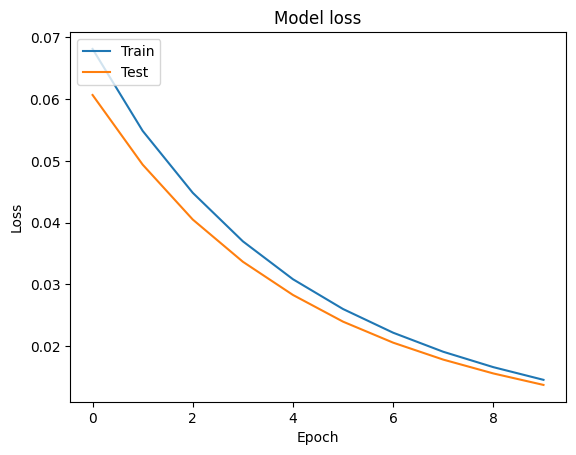

In [16]:
import matplotlib.pyplot as plt

# 모델 학습
history = model.fit({'theta_input': theta_train, 'phi_input': phi_train, 'sequence_input': sequence_train}, np.expand_dims(sequence_train, -1), epochs=10, validation_data=({'theta_input': theta_test, 'phi_input': phi_test, 'sequence_input': sequence_test}, np.expand_dims(sequence_test, -1)))

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


Epoch 1/50
20/20 [==============================] - 2s 22ms/step - loss: 1.3444 - accuracy: 0.4599 - val_loss: 1.0677 - val_accuracy: 0.5948
Epoch 2/50
20/20 [==============================] - 0s 11ms/step - loss: 0.9380 - accuracy: 0.6800 - val_loss: 0.7620 - val_accuracy: 0.7641
Epoch 3/50
20/20 [==============================] - 0s 10ms/step - loss: 0.6699 - accuracy: 0.8337 - val_loss: 0.4818 - val_accuracy: 0.8724
Epoch 4/50
20/20 [==============================] - 0s 10ms/step - loss: 0.3929 - accuracy: 0.8863 - val_loss: 0.3102 - val_accuracy: 0.8928
Epoch 5/50
20/20 [==============================] - 0s 9ms/step - loss: 0.2794 - accuracy: 0.9131 - val_loss: 0.2464 - val_accuracy: 0.9356
Epoch 6/50
20/20 [==============================] - 0s 9ms/step - loss: 0.2221 - accuracy: 0.9421 - val_loss: 0.2105 - val_accuracy: 0.9345
Epoch 7/50
20/20 [==============================] - 0s 9ms/step - loss: 0.1732 - accuracy: 0.9597 - val_loss: 0.1473 - val_accuracy: 0.9640
Epoch 8/50
20/20

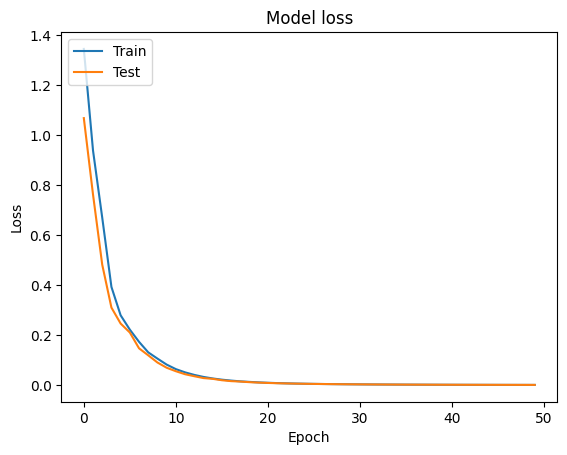

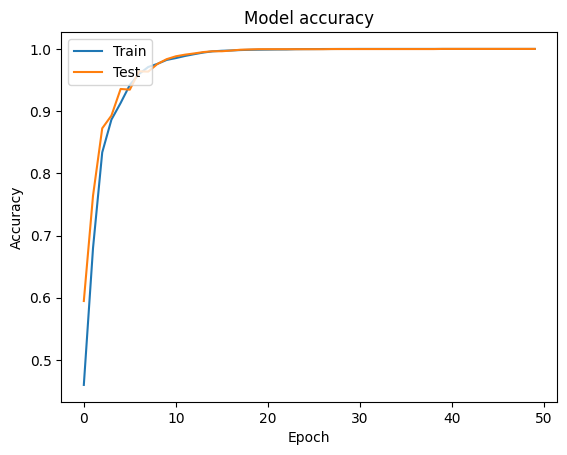

25/25 [==============================] - 0s 3ms/step - loss: 9.7658e-04 - accuracy: 1.0000
Accuracy: 100.00


In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Embedding, RepeatVector, Concatenate, TimeDistributed
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

class RNNModel:
    def __init__(self, max_seq_length):
        # 모델 구성
        theta_input = Input(shape=(1,), name='theta_input')
        phi_input = Input(shape=(1,), name='phi_input')
        sequence_input = Input(shape=(max_seq_length,), name='sequence_input')

        theta_repeated = RepeatVector(max_seq_length)(theta_input)
        phi_repeated = RepeatVector(max_seq_length)(phi_input)
        sequence_embedding = Embedding(5, 32, input_length=max_seq_length)(sequence_input)

        concat_layer = Concatenate()([theta_repeated, phi_repeated, sequence_embedding])
        rnn_layer = SimpleRNN(32, return_sequences=True)(concat_layer)
        rnn_layer2 = SimpleRNN(64, return_sequences=True)(rnn_layer)
        output = TimeDistributed(Dense(5, activation='softmax'))(rnn_layer2)

        self.model = Model(inputs=[theta_input, phi_input, sequence_input], outputs=output)
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    def fit(self, theta, phi, sequence, epochs=50):
        sequence_train, sequence_val, theta_train, theta_val, phi_train, phi_val = train_test_split(sequence, theta, phi, test_size=0.2)

        self.history = self.model.fit(
            {'theta_input': theta_train, 'phi_input': phi_train, 'sequence_input': sequence_train},
            np.expand_dims(sequence_train, -1), 
            validation_data=({'theta_input': theta_val, 'phi_input': phi_val, 'sequence_input': sequence_val}, np.expand_dims(sequence_val, -1)),
            epochs=epochs)

    def plot_history(self):
        # Plot training & validation loss values
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

        # Plot training & validation accuracy values
        plt.plot(self.history.history['accuracy'])
        plt.plot(self.history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

    def evaluate(self, theta, phi, sequence):
        loss, acc = self.model.evaluate({'theta_input': theta, 'phi_input': phi, 'sequence_input': sequence}, np.expand_dims(sequence, -1))
        print("Accuracy: {:.2f}".format(acc*100))

# CSV 파일에서 데이터 읽기
df = pd.read_csv('ByAstar_20230627_093742.csv')
theta = df['Theta'].values.reshape(-1, 1)
phi = df['Phi'].values.reshape(-1, 1)
sequence = df['combination'].apply(eval).to_list()
max_seq_length = max(len(seq) for seq in sequence)
sequence_padded = pad_sequences(sequence, maxlen=max_seq_length)

# 모델 초기화
rnn_model = RNNModel(max_seq_length)

# 모델 학습
rnn_model.fit(theta, phi, sequence_padded)

# 결과 그래프 그리기
rnn_model.plot_history()

# 모델 성능 평가
rnn_model.evaluate(theta, phi, sequence_padded)
